In [1]:
# Let`s import all packages that we may need:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split, cross_val_score # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler # for normalization
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential, model_from_json
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline # pipeline making
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [6]:
import pandas as pd
data=pd.read_csv('data_for_5_zones.csv',infer_datetime_format=True,   parse_dates=  ['date_time']  )

In [7]:
data = data.drop('date',axis=1)

In [8]:
data.head()

,Temperature,date_time,usage,zone_id
0,46,2004-01-01 01:00:00,16853,1
1,46,2004-01-01 02:00:00,16450,1
2,45,2004-01-01 03:00:00,16517,1
3,41,2004-01-01 04:00:00,16873,1
4,39,2004-01-01 05:00:00,17064,1


# Feature engineering

### Adding more features to data... is_weekend or is_holiday

In [9]:
 data["DAY_TYPE"] = data.date_time.apply(lambda x: 1 if x.dayofweek > 5 else 0  )

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start = data.date_time.min(), end = data.date_time.max())
data["IS_HOLIDAY"] = data.date_time.isin(holidays) 
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")

In [11]:
data.to_csv('full_features.csv',index=False)

##  new data

In [49]:
data = pd.read_csv('full_features.csv',infer_datetime_format=True,parse_dates={'datetime' : ['date_time']} ,index_col='datetime' )

In [50]:
data.head()

,Temperature,usage,zone_id,DAY_TYPE,IS_HOLIDAY
datetime,,,,,
2004-01-01 01:00:00,46,16853,1,0,0
2004-01-01 02:00:00,46,16450,1,0,0
2004-01-01 03:00:00,45,16517,1,0,0
2004-01-01 04:00:00,41,16873,1,0,0
2004-01-01 05:00:00,39,17064,1,0,0


## different models for different zones

In [51]:
df_resample = data[data['zone_id']==1.0]

### making time series prediction as a supervised prediction

In [52]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #if n_out=2 is to predict next to next value
    n_vars = data.columns
    dff = data
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('%s(t-%d)' % (each, i)) for each in (n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('%s(t)' % (each)) for each in (n_vars)]
        else:
            names += [('each(t+%d)' % (each, i)) for each in (n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


###  feature scaling the values

In [53]:
i=1 #since zone id = 1

In [54]:
from sklearn.preprocessing import MinMaxScaler
values = df_resample.values 
cols = df_resample.columns
# integer encode direction
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


scaler_filename = 'scaler'+ str(i) + '.save'
joblib.dump(scaler, scaler_filename) 
# frame as supervised learning
scaled = pd.DataFrame(scaled,columns=cols)
reframed = series_to_supervised(scaled, 1, 1)



/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### drop columns we don't want to predict

In [55]:
reframed.head()

,Temperature(t-1),usage(t-1),zone_id(t-1),DAY_TYPE(t-1),IS_HOLIDAY(t-1),Temperature(t),usage(t),zone_id(t),DAY_TYPE(t),IS_HOLIDAY(t)
0,NaN,NaN,NaN,NaN,NaN,0.373626,0.249398,0.0,0.0,0.0
1,0.373626,0.249398,0.0,0.0,0.0,0.373626,0.238856,0.0,0.0,0.0
2,0.373626,0.238856,0.0,0.0,0.0,0.362637,0.240609,0.0,0.0,0.0
3,0.362637,0.240609,0.0,0.0,0.0,0.318681,0.249922,0.0,0.0,0.0
4,0.318681,0.249922,0.0,0.0,0.0,0.296703,0.254918,0.0,0.0,0.0


In [56]:
reframed.drop(['Temperature(t)','zone_id(t)', 'DAY_TYPE(t)','IS_HOLIDAY(t)'], axis=1, inplace=True)
reframed.head()

,Temperature(t-1),usage(t-1),zone_id(t-1),DAY_TYPE(t-1),IS_HOLIDAY(t-1),usage(t)
0,NaN,NaN,NaN,NaN,NaN,0.249398
1,0.373626,0.249398,0.0,0.0,0.0,0.238856
2,0.373626,0.238856,0.0,0.0,0.0,0.240609
3,0.362637,0.240609,0.0,0.0,0.0,0.249922
4,0.318681,0.249922,0.0,0.0,0.0,0.254918


###  saving the reframed object as csv file

In [57]:
reframed.to_csv('reframed.csv',index=False)

In [2]:
reframed = pd.read_csv('reframed.csv')

#  train_test_split

In [3]:
# split into train and test sets
values = reframed.values

n_train_time = int(reframed.shape[0]*0.7)
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :].............n_train_time= index of row from which training to be started

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


###  reshaping according to lstm used here

In [4]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(26436, 1, 5) (26436,) (11330, 1, 5) (11330,)


In [5]:
X_train , y_train , X_test, y_test=  train_X, train_y, test_X, test_y

### Model architecture
### 1) LSTM with 100 neurons in the first visible layer
### 3) dropout 20%
### 4) 1 neuron in the output layer for predicting Global_active_power.
### 5) The input shape will be 1 time step with 7 features.
### 6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
### 7) The model will be fit for 20 training epochs with a batch size of 70.

In [6]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# fit network
# summarize history for loss
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# saving the model
model_json = model.to_json()
with open('model'+ str(i) + '.json' , "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('model'+ str(i) + '.h5')



Train on 26436 samples, validate on 11330 samples
Epoch 1/20
2422s - loss: nan - val_loss: nan
Epoch 2/20
2426s - loss: nan - val_loss: nan
Epoch 3/20


KeyboardInterrupt: 

### making predictions

In [16]:
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model

loaded_model.load_weights("model1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
#score = loaded_model.evaluate(X, Y, verbose=0)

Loaded model from disk


In [17]:
model = loaded_model

### prediction

In [18]:

yhat = model.predict(X_test)

### again reshaping x_test just to compare y_true with y_pred

In [20]:
test_X = test_X.reshape((test_X.shape[0], 5))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1) # saare features milaaye prediction feature k sath..kyunkin scaler is fitted on all features 
inv_yhat = scaler.inverse_transform(inv_yhat) #scaler inv transform
inv_yhat = inv_yhat[:,0] # now actual predicted value
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]



In [21]:
y_actual = pd.DataFrame(data=[inv_y])
y_pred = pd.DataFrame(data=[inv_yhat])


In [22]:
y_pred = y_pred.T

In [23]:
y_actual = y_actual.T

In [24]:
output = pd.concat([y_actual,y_pred], axis=1)

In [25]:
output.columns = ['actual', 'predicted']

In [26]:
output.head()

,actual,predicted
0,98259.691156,99731.560661
1,98532.730421,99381.879030
2,100413.796907,99671.918553
3,104023.063861,101671.855622
4,105463.419217,105517.926157


In [27]:
output.to_csv('lstm_output1.csv',index=False)

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

In [33]:
actual=output['actual'][:30]

In [34]:
pred = output['predicted'][:30]

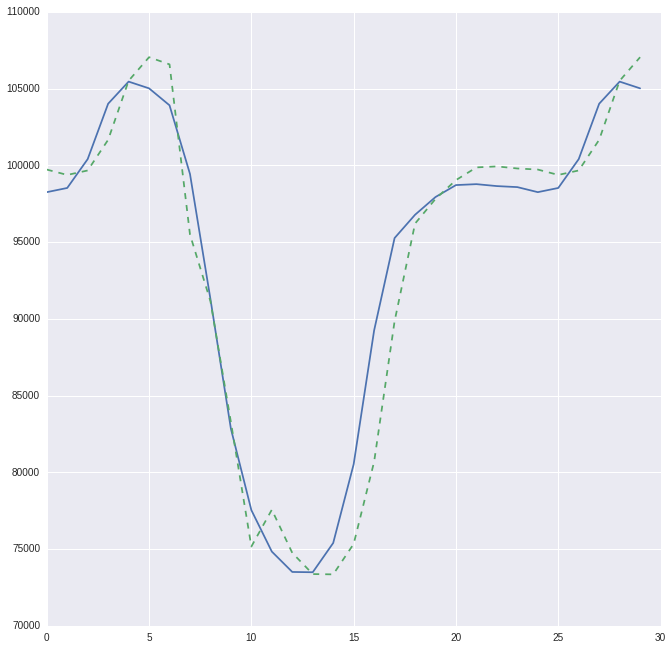

In [37]:
plt.figure(figsize=(11,11))
plt.plot(actual,'-')
plt.plot(pred,'--')
plt.show()

#### data related

#### model related